# Project Overview:

URL: "https://www.kaggle.com/datasets/paultimothymooney/chest-xray-pneumonia"

The Kaggle dataset above shows multiple chest X-rays of patients who either had pneumonia or no illness at all. 

The hope of this project is to create several different Neural Networks:

1. *Simple Convulutional Neural Networks*
2. *Complex Convulutional Neural Networks* 
3. *ResNet Neural Network
4. *Use Data Augmentation to see different results* 

and use TensorFlow/Keras to properly and accurately predict whether an X-ray image has pneumonia or nothing at all. 

Some things to note on this project are:


1.   We are using an already pre-processed dataset. The datasets are broken into train, test, and val folders
> Within those folders we have the images already classified as either Normal or Pneumonia


2.   In order to not bog down Google Colab, we will be running a small amount of neural networks. To properly optimize the model, we could play with various variables (learning rate, epoch sizes, batch sizes)...but for our purposes here, we'll be running small sizes so the program runs quickly. Note that the ResNet model is pre-trained, and due to its size, it takes a massive amount of time to run. 

**NOTE** - I attempted to use ResNet50...but it was very difficult to incorporate on this dataset.

## Import Modules

First thing to do is to import all the modules


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

import tensorflow as tf
import keras
from keras import optimizers, losses, metrics
from keras.models import Sequential
from keras.layers import Input, Dense, Conv2D, MaxPool2D, Flatten, Dropout, BatchNormalization, GlobalAveragePooling2D
from keras.callbacks import ReduceLROnPlateau, EarlyStopping
from keras.utils import plot_model
from keras.optimizers import Adam
from keras.metrics import CategoricalAccuracy, AUC
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.resnet import ResNet50

from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split

import cv2
import os

## Import Datasets

Now we import the data we'll be working with

In [3]:
#all modules have been imported, now download dataset from Kaggle
url = "https://www.kaggle.com/pranavraikokte/covid19-image-dataset"

from google.colab import drive
drive.mount('/content/gdrive')


Mounted at /content/gdrive


In [4]:
import os
os.environ['KAGGLE_CONFIG_DIR'] = "/content/gdrive/My Drive/Kaggle"

#changing the working directory
%cd /content/gdrive/My Drive/Kaggle



/content/gdrive/My Drive/Kaggle


In [5]:
pwd

'/content/gdrive/My Drive/Kaggle'

In [5]:
ls

chest_xray/                   complex-cnn-for-pneumonia.png
complex-cnn-for-covid-19.png  simple_cnn_model.png


In [6]:
%cd /content/gdrive/My Drive/Kaggle/chest_xray

/content/gdrive/My Drive/Kaggle/chest_xray


In [7]:
# #unzipping the zip files and deleting the zip files
# !unzip \*.zip  && rm *.zip

We have our modules, and we have our dataset.

We're ready now to start our data processing and modeling...

## Data Pre-Processing

First thing we want to do is create a training and a test iterator/generator

In [6]:
#hardcoded variables

LABELS = ['PNEUMONIA', 'NORMAL']

In [7]:
# this is the Image Generator for our images
# At the end, we will use this for model tuning and optimzation
# one way of tuning the model and hyperparameters for image classification is doing image augmentation
# the code below is for that image augmentation

#start with NO IMAGE AUGMENTATION
image_generator = ImageDataGenerator(
        featurewise_center = False,  # set input mean to 0 over the dataset
        samplewise_center = False,  # set each sample mean to 0
        featurewise_std_normalization = False,  # divide inputs by std of the dataset
        samplewise_std_normalization = False,  # divide each input by its std
        zca_whitening = False,  # apply ZCA whitening
        rotation_range = 0,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0, # Randomly zoom image 
        width_shift_range = 0,  # randomly shift images horizontally (fraction of total width)
        height_shift_range = 0,  # randomly shift images vertically (fraction of total height)
        horizontal_flip = False,  # randomly flip images
        vertical_flip = False)  # randomly flip images

In [8]:
def iterator(data_generator, directory, class_mode, color_mode, batch_size, target_size):
  iterator = data_generator.flow_from_directory(directory,
                                                class_mode = class_mode, 
                                                color_mode = color_mode,
                                                batch_size = batch_size,
                                                target_size = target_size,
                                                seed = 500)
  return iterator

In [11]:
train = iterator(
    data_generator = image_generator,
    directory = '/content/gdrive/MyDrive/Kaggle/Covid19-dataset/train', 
    class_mode = 'categorical', 
    color_mode = 'grayscale', 
    batch_size = 10,
    target_size = (224, 224))

train

Found 251 images belonging to 3 classes.


In [13]:
test = iterator(
    data_generator = image_generator,
    directory = '/content/gdrive/MyDrive/Kaggle/Covid19-dataset/test', 
    class_mode = 'categorical', 
    color_mode = 'grayscale', 
    batch_size = 10,
    target_size = (224, 224))

test

Found 66 images belonging to 3 classes.


In [10]:
train = image_generator.flow_from_directory('/content/gdrive/MyDrive/Kaggle/chest_xray/train', 
                                            batch_size=8, 
                                            shuffle=True, 
                                            class_mode='binary',
                                            target_size=(180, 180))

test = image_generator.flow_from_directory('/content/gdrive/MyDrive/Kaggle/chest_xray/test', 
                                            batch_size=8, 
                                            shuffle=True, 
                                            class_mode='binary',
                                            target_size=(180, 180))

val = image_generator.flow_from_directory('/content/gdrive/MyDrive/Kaggle/chest_xray/val', 
                                            batch_size=8, 
                                            shuffle=True, 
                                            class_mode='binary',
                                            target_size=(180, 180))

Found 5202 images belonging to 2 classes.
Found 624 images belonging to 2 classes.
Found 16 images belonging to 2 classes.


## Creating Our Various Models

We've got the training, test, and validation iterators (and necessary information on each)...we can start creating our various models now

### Simple CNN Model

For this model, we will create a simple convulutional neural network. The idea behind this is it not having too many layers, and being able to see the results at each layer. Small parameters, small runtime, and hopefully see some decent results.

#### Build our Model

In [14]:
def simple_cnn_model(input_shape, learning_rate):
  """
  create a simple CNN with only 2 layers
  """

  #start with the model
  model = Sequential()

  #add out input layer first
  model.add(Input(shape = input_shape))

  #add our first Conv2D layer
  model.add(Conv2D(2, 
                  (3,3), 
                   strides = 1, 
                   activation = 'relu'))

  #add our MaxPool2D layer
  model.add(MaxPool2D((2,2), 
                      strides = 2, 
                      padding = 'same'))

  #for simplicity, just keep 2 layers
  model.add(Conv2D(4, 
                  (3,3), 
                   strides = 1, 
                   activation = 'relu'))

  #our second maxpool2d layer
  model.add(MaxPool2D((2,2), 
                      strides = 2, 
                      padding = 'same'))

  #flatten all the layers
  model.add(Flatten())

  #create our dense layer
  model.add(Dense(4, activation = 'relu'))

  #create our dense layer with the sigmoid activation
  model.add(Dense(1 , activation = 'sigmoid'))
  
  #lastly, compile the model with optimzer, loss, and metrics parameters
  model.compile(optimizer = Adam(learning_rate = learning_rate), 
                loss = 'binary_crossentropy', 
                metrics = ['accuracy',
                           AUC()])
  
  return model


In [12]:
#get our model
simple_cnn_model = simple_cnn_model(0.001)

We've created our model with our selected parameters, so let's just see the models summary and see the amount of parameters we're working with


In [13]:
#let's see our model summary
simple_cnn_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 178, 178, 2)       56        
                                                                 
 max_pooling2d (MaxPooling2D  (None, 89, 89, 2)        0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 87, 87, 4)         76        
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 44, 44, 4)        0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 7744)              0         
                                                                 
 dense (Dense)               (None, 4)                 3

#### Fit The Model

We've created our model above, now we can run it through our function to fit it.

In [14]:
def fit_model(model, early_stop_monitor, early_stop_patience, batch_size, epochs, class_weight):

  #get our early stopping variable here
  early_stop = EarlyStopping(
      monitor = early_stop_monitor,
      patience = early_stop_patience)
  

  #now get the history object of the model
  print("Training the model. This may take a while...")
  history = model.fit(train,
                    epochs = epochs, 
                    validation_data = test,
                    class_weight=class_weight,
                    callbacks = [early_stop])

  return history

In [15]:
#hardcoded variables for the model fitting process.
MONITOR = 'loss'
PATIENCE = 2
BATCH_SIZE = 32
EPOCHS = 10

num_pneumonia = len(os.listdir(os.path.join('/content/gdrive/MyDrive/Kaggle/chest_xray/train', 'PNEUMONIA')))
num_normal = len(os.listdir(os.path.join('/content/gdrive/MyDrive/Kaggle/chest_xray/train', 'NORMAL')))
weight_for_0 = num_pneumonia / (num_normal + num_pneumonia)
weight_for_1 = num_normal / (num_normal + num_pneumonia)

CLASS_WEIGHT = {0: weight_for_0, 1: weight_for_1}

In [16]:
#now fit the model and save the variable so can run some analysis later
simple_cnn_fit = fit_model(simple_cnn_model, MONITOR, PATIENCE, BATCH_SIZE, EPOCHS, CLASS_WEIGHT)

Training the model. This may take a while...
Epoch 1/10
651/651 [==============================] - 1103s 2s/step - loss: 0.2745 - accuracy: 0.4962 - auc: 0.4913 - val_loss: 0.6921 - val_accuracy: 0.6250 - val_auc: 0.5000
Epoch 2/10
651/651 [==============================] - 172s 265ms/step - loss: 0.2653 - accuracy: 0.6423 - auc: 0.4957 - val_loss: 0.6931 - val_accuracy: 0.6250 - val_auc: 0.5000
Epoch 3/10
651/651 [==============================] - 159s 244ms/step - loss: 0.2653 - accuracy: 0.5038 - auc: 0.4985 - val_loss: 0.6926 - val_accuracy: 0.6250 - val_auc: 0.5000
Epoch 4/10
651/651 [==============================] - 169s 259ms/step - loss: 0.2653 - accuracy: 0.7061 - auc: 0.4945 - val_loss: 0.6937 - val_accuracy: 0.3750 - val_auc: 0.5000
Epoch 5/10
651/651 [==============================] - 176s 270ms/step - loss: 0.2653 - accuracy: 0.3378 - auc: 0.5000 - val_loss: 0.6933 - val_accuracy: 0.3750 - val_auc: 0.5000
Epoch 6/10
651/651 [==============================] - 169s 260ms/st

Perfect! We've fit our model, check the results

In [17]:
evaluation = simple_cnn_model.evaluate(test)
print(f"Test Accuracy: {evaluation[1] * 100:.2f}%")

evaluation = simple_cnn_model.evaluate(train)
print(f"Train Accuracy: {evaluation[1] * 100:.2f}%")

78/78 [==============================] - 13s 163ms/step - loss: 0.6925 - accuracy: 0.6250 - auc: 0.5000
Test Accuracy: 62.50%
651/651 [==============================] - 117s 179ms/step - loss: 0.6919 - accuracy: 0.7422 - auc: 0.5000
Train Accuracy: 74.22%


#### Visualize the Results of the Model

Let's see our model and how accurate it was. 

We are going to be plotting accuracy versus epoch, and AUC versus epoch

In [18]:
def visualize_accuracy(model):
    # plotting categorical and validation accuracy over epochs
    fig = plt.figure(figsize = (14,8))
    ax1 = fig.add_subplot(2, 1, 1)
    ax1.plot(model.history['accuracy'])
    ax1.plot(model.history['val_accuracy'])
    ax1.set_title('model accuracy')
    ax1.set_xlabel('epoch')
    ax1.set_ylabel('accuracy')
    ax1.legend(['train', 'validation'], loc='upper left')

    # plotting auc and validation auc over epochs
    keys = list(model.history.keys())
    ax2 = fig.add_subplot(2, 1, 2)
    ax2.plot(model.history[keys[2]])
    ax2.plot(model.history[keys[-1]])
    ax2.set_title('model auc')
    ax2.set_xlabel('epoch')
    ax2.set_ylabel('auc')
    ax2.legend(['train', 'validation'], loc='upper left')

    plt.tight_layout()
    plt.show()

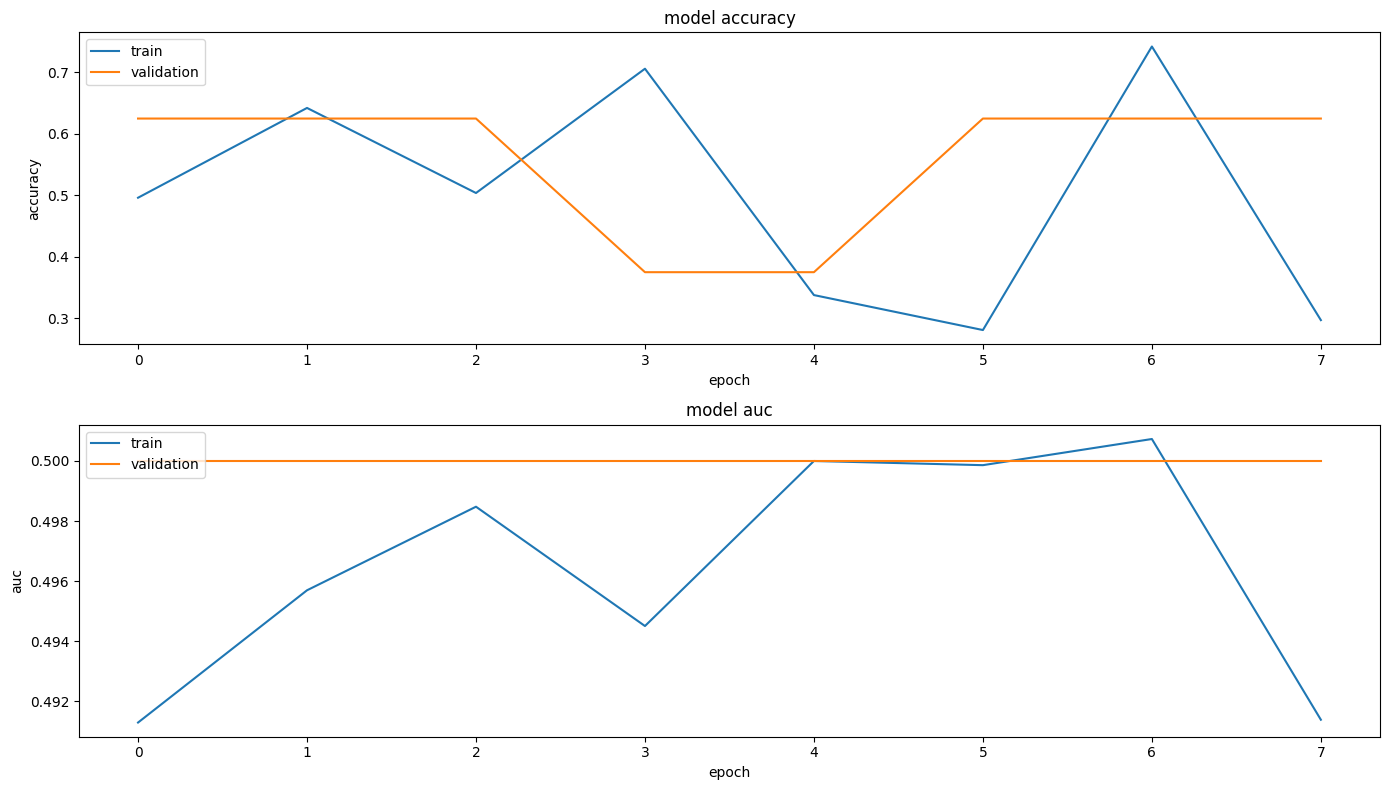

In [19]:
visualize_accuracy(simple_cnn_fit)

#### Create Statistical Reports

We've seen the loss metrics visually, lets also see the classification report and the confusion matrix, and compare how the model does on the actual test set.

In [20]:
def class_report(model):
  pred = model.predict(test)

  print(confusion_matrix(test.classes, pred > 0.5))
  report = pd.DataFrame(classification_report(test.classes, pred > 0.5, output_dict=True))

  print("Our classification report is: ")
  print(report)

In [21]:
class_report(simple_cnn_model)

78/78 [==============================] - 12s 146ms/step
[[  0 234]
 [  0 390]]
Our classification report is: 
               0           1  accuracy   macro avg  weighted avg
precision    0.0    0.625000     0.625    0.312500      0.390625
recall       0.0    1.000000     0.625    0.500000      0.625000
f1-score     0.0    0.769231     0.625    0.384615      0.480769
support    234.0  390.000000     0.625  624.000000    624.000000


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


#### Plot Keras Model Breakdown

Keras has a very neat feature built in that actually shows the breakdown of the model. It cleanly shows the layers, the direction the data travels, the input and output size, and finally the output all in graph form

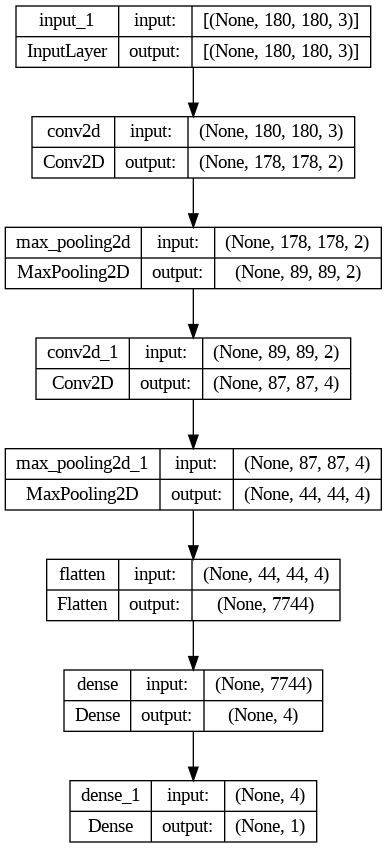

In [22]:
#show our plot_model and then save that file so we can put in the presentation
plot_model(simple_cnn_model, to_file='simple_cnn_model.png', show_shapes=True)

### Complex CNN Model

#### Build Model Class

In [23]:
def create_complex_cnn_model(learning_rate):

  """
  a CNN with multiple layers
  """

  
  #start with the model
  model = Sequential()

  #add out input layer first
  model.add(Input(shape = (180, 180, 3)))

  #add our first Conv2D layer
  model.add(Conv2D(32, 
                  (3,3), 
                   strides = 1, 
                   padding = 'same', 
                   activation = 'relu'))

  #add our MaxPool2D layer
  model.add(MaxPool2D((2,2), 
                      strides = 2, 
                      padding = 'same'))

  #for simplicity, just keep 2 layers
  model.add(Conv2D(64, 
                  (3,3), 
                   strides = 2, 
                   padding = 'same', 
                   activation = 'relu'))

  #another maxpool2d layer
  model.add(MaxPool2D((2,2), 
                      strides = 2, 
                      padding = 'same'))
  
  #another conv2d layer
  model.add(Conv2D(64, 
                  (3,3), 
                   strides = 1, 
                   padding = 'same', 
                   activation = 'relu'))

  #another maxpool layer
  model.add(MaxPool2D((2,2), 
                      strides = 2, 
                      padding = 'same'))
  
  #last conv2d layer
  model.add(Conv2D(128, 
                  (3,3), 
                   strides = 1, 
                   padding = 'same', 
                   activation = 'relu'))

  #last maxpool layer
  model.add(MaxPool2D((2,2), 
                      strides = 2, 
                      padding = 'same'))
  
  #flatten our layers
  model.add(Flatten())

  #create our dense layer
  model.add(Dense(128, activation = 'relu'))

  #create our dense layer with the sigmoid activation
  model.add(Dense(1 , activation = 'sigmoid'))
  
  #lastly, compile the model with optimzer, loss, and metrics parameters
  model.compile(optimizer = Adam(learning_rate = learning_rate), 
                loss = 'binary_crossentropy', 
                metrics = ['accuracy',
                           AUC()])
  
  return model


In [24]:
complex_cnn_model = create_complex_cnn_model(0.001)
complex_cnn_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 180, 180, 32)      896       
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 90, 90, 32)       0         
 2D)                                                             
                                                                 
 conv2d_3 (Conv2D)           (None, 45, 45, 64)        18496     
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 23, 23, 64)       0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 23, 23, 64)        36928     
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 12, 12, 64)      

#### Fit The Model

In [25]:
complex_cnn_fit = fit_model(complex_cnn_model, MONITOR, PATIENCE, BATCH_SIZE, EPOCHS, CLASS_WEIGHT)

Training the model. This may take a while...
Epoch 1/10
651/651 [==============================] - 285s 436ms/step - loss: 0.1609 - accuracy: 0.8860 - auc_1: 0.9492 - val_loss: 0.8088 - val_accuracy: 0.8205 - val_auc_1: 0.9005
Epoch 2/10
651/651 [==============================] - 279s 427ms/step - loss: 0.0561 - accuracy: 0.9394 - auc_1: 0.9859 - val_loss: 0.6173 - val_accuracy: 0.8205 - val_auc_1: 0.8992
Epoch 3/10
651/651 [==============================] - 276s 424ms/step - loss: 0.0471 - accuracy: 0.9512 - auc_1: 0.9898 - val_loss: 0.8030 - val_accuracy: 0.8237 - val_auc_1: 0.8914
Epoch 4/10
651/651 [==============================] - 286s 439ms/step - loss: 0.0376 - accuracy: 0.9610 - auc_1: 0.9929 - val_loss: 1.3617 - val_accuracy: 0.7821 - val_auc_1: 0.8460
Epoch 5/10
651/651 [==============================] - 289s 443ms/step - loss: 0.0440 - accuracy: 0.9567 - auc_1: 0.9908 - val_loss: 0.8779 - val_accuracy: 0.7901 - val_auc_1: 0.8629
Epoch 6/10
651/651 [=========================

#### Vizualize the Results of the Model

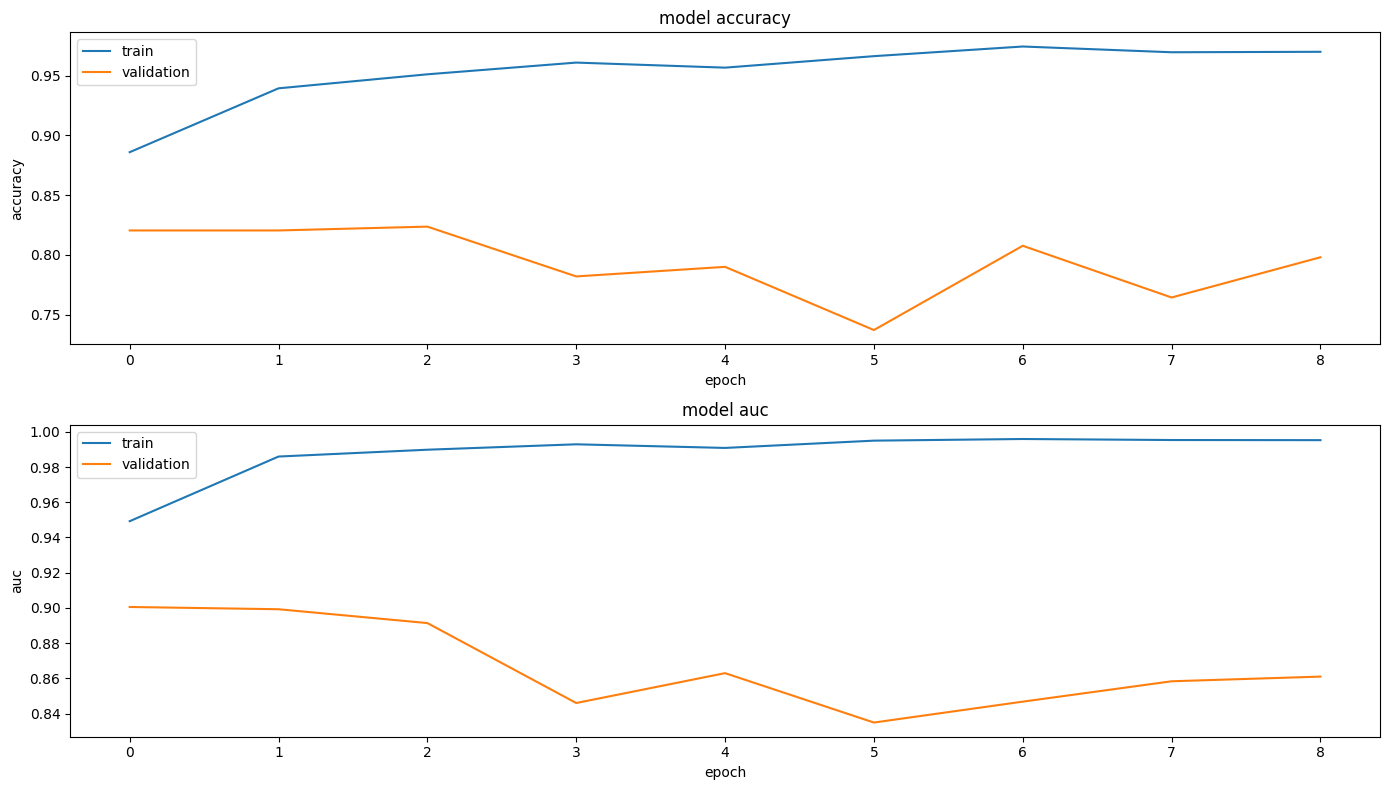

In [26]:
visualize_accuracy(complex_cnn_fit)

#### Create Statistical Reports

In [27]:
complex_cnn_class_report = class_report(complex_cnn_model)

78/78 [==============================] - 15s 190ms/step
[[ 51 183]
 [ 87 303]]
Our classification report is: 
                    0           1  accuracy   macro avg  weighted avg
precision    0.369565    0.623457  0.567308    0.496511      0.528247
recall       0.217949    0.776923  0.567308    0.497436      0.567308
f1-score     0.274194    0.691781  0.567308    0.482987      0.535186
support    234.000000  390.000000  0.567308  624.000000    624.000000


In [39]:
evaluation = complex_cnn_model.evaluate(test)
print(f"Test Accuracy: {evaluation[1] * 100:.2f}%")

evaluation = complex_cnn_model.evaluate(train)
print(f"Train Accuracy: {evaluation[1] * 100:.2f}%")

78/78 [==============================] - 16s 199ms/step - loss: 1.4699 - accuracy: 0.7981 - auc_1: 0.8610
Test Accuracy: 79.81%
651/651 [==============================] - 141s 216ms/step - loss: 0.1021 - accuracy: 0.9673 - auc_1: 0.9965
Train Accuracy: 96.73%


#### Plot Keras Model Breakdown

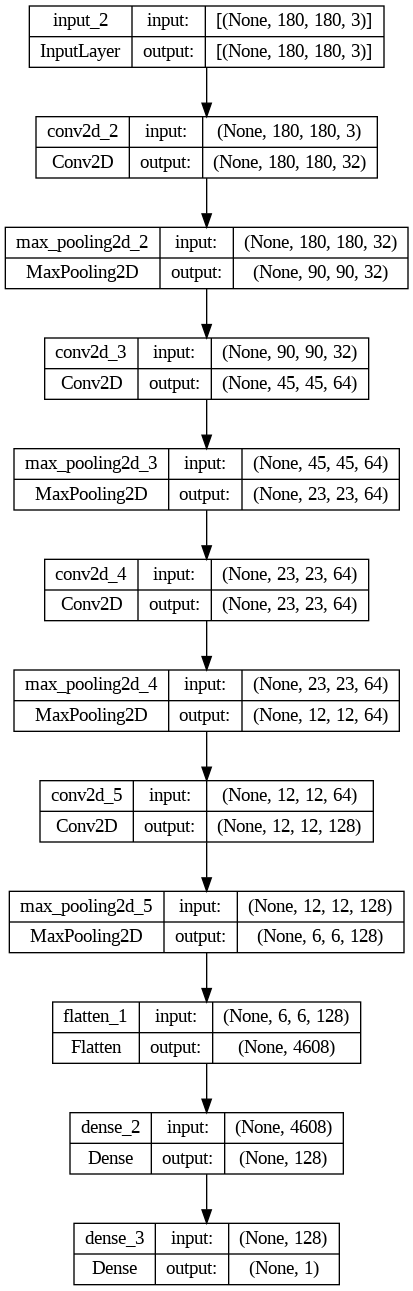

In [28]:
plot_model(complex_cnn_model, to_file='complex-cnn-for-pneumonia.png', show_shapes=True)

## Data Augmentation!


In Deep Learning, there are multiple ways of tweaking models and optimizing them:
  1. Tweak the hyperparameters
    - this means tweaking things like the hidden layers, batch size, epochs, and/or learning rate
  2. Tweak the layers
    - Add of subtract Conv2D layers with different activation functions and/or padding variables
  3. The one we will talk a bit about here -- Data Augmentation

In data augmentation, rather than changing the models parameters, we actually manipulate the input data. Since we are working with images, the changes that we do can be found in the arguments of *ImageDataGenerator* - but on a high level, we are going to be rotating the photos, randomly flipping some photos horizontally and/or vertically, and/or shift the center of the image in any direction.

The reason for the data augmentation is to ensure the model doesnt just train on the same photos in continuous order and develop any sort of bias - so by augmenting the images, we hope the model will learn better.

Here, we're going to run the data augmentation on the complex CNN model and see the results from there (not doing it on the ResNet as the ResNet model fitting takes an enormously long time).

### Augment the Data

In [29]:
# this is the Image Generator for our images
# At the end, we will use this for model tuning and optimzation
# one way of tuning the model and hyperparameters for image classification is doing image augmentation
# the code below is for that image augmentation

#start with NO IMAGE AUGMENTATION
datagen = ImageDataGenerator(
        featurewise_center = False,  # set input mean to 0 over the dataset
        samplewise_center = False,  # set each sample mean to 0
        featurewise_std_normalization = False,  # divide inputs by std of the dataset
        samplewise_std_normalization = False,  # divide each input by its std
        zca_whitening = False,  # apply ZCA whitening
        rotation_range = 30,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.15, # Randomly zoom image 
        width_shift_range = 0.15,  # randomly shift images horizontally (fraction of total width)
        height_shift_range = 0.15,  # randomly shift images vertically (fraction of total height)
        horizontal_flip = True,  # randomly flip images
        vertical_flip = True)  # randomly flip images


### Build the Model

In [30]:
aug_complex_cnn_model = create_complex_cnn_model(0.01)

In [31]:
aug_complex_cnn_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 180, 180, 32)      896       
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 90, 90, 32)       0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (None, 45, 45, 64)        18496     
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 23, 23, 64)       0         
 2D)                                                             
                                                                 
 conv2d_8 (Conv2D)           (None, 23, 23, 64)        36928     
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 12, 12, 64)      

### Fit the Model

In [32]:
aug_complex_cnn_fit = fit_model(aug_complex_cnn_model, MONITOR, PATIENCE, BATCH_SIZE, EPOCHS, CLASS_WEIGHT)

Training the model. This may take a while...
Epoch 1/10
651/651 [==============================] - 286s 438ms/step - loss: 2.2420 - accuracy: 0.6934 - auc_2: 0.7335 - val_loss: 1.3488 - val_accuracy: 0.6250 - val_auc_2: 0.6930
Epoch 2/10
651/651 [==============================] - 292s 449ms/step - loss: 0.3428 - accuracy: 0.5600 - auc_2: 0.5891 - val_loss: 0.7042 - val_accuracy: 0.6186 - val_auc_2: 0.4974
Epoch 3/10
651/651 [==============================] - 284s 436ms/step - loss: 0.2696 - accuracy: 0.5037 - auc_2: 0.4974 - val_loss: 0.6864 - val_accuracy: 0.6250 - val_auc_2: 0.5000
Epoch 4/10
651/651 [==============================] - 291s 448ms/step - loss: 0.2658 - accuracy: 0.5169 - auc_2: 0.4840 - val_loss: 0.7001 - val_accuracy: 0.3750 - val_auc_2: 0.5000
Epoch 5/10
651/651 [==============================] - 269s 413ms/step - loss: 0.2655 - accuracy: 0.5210 - auc_2: 0.4996 - val_loss: 0.7090 - val_accuracy: 0.3750 - val_auc_2: 0.5000
Epoch 6/10
651/651 [=========================

### Visualize the Results of the Model

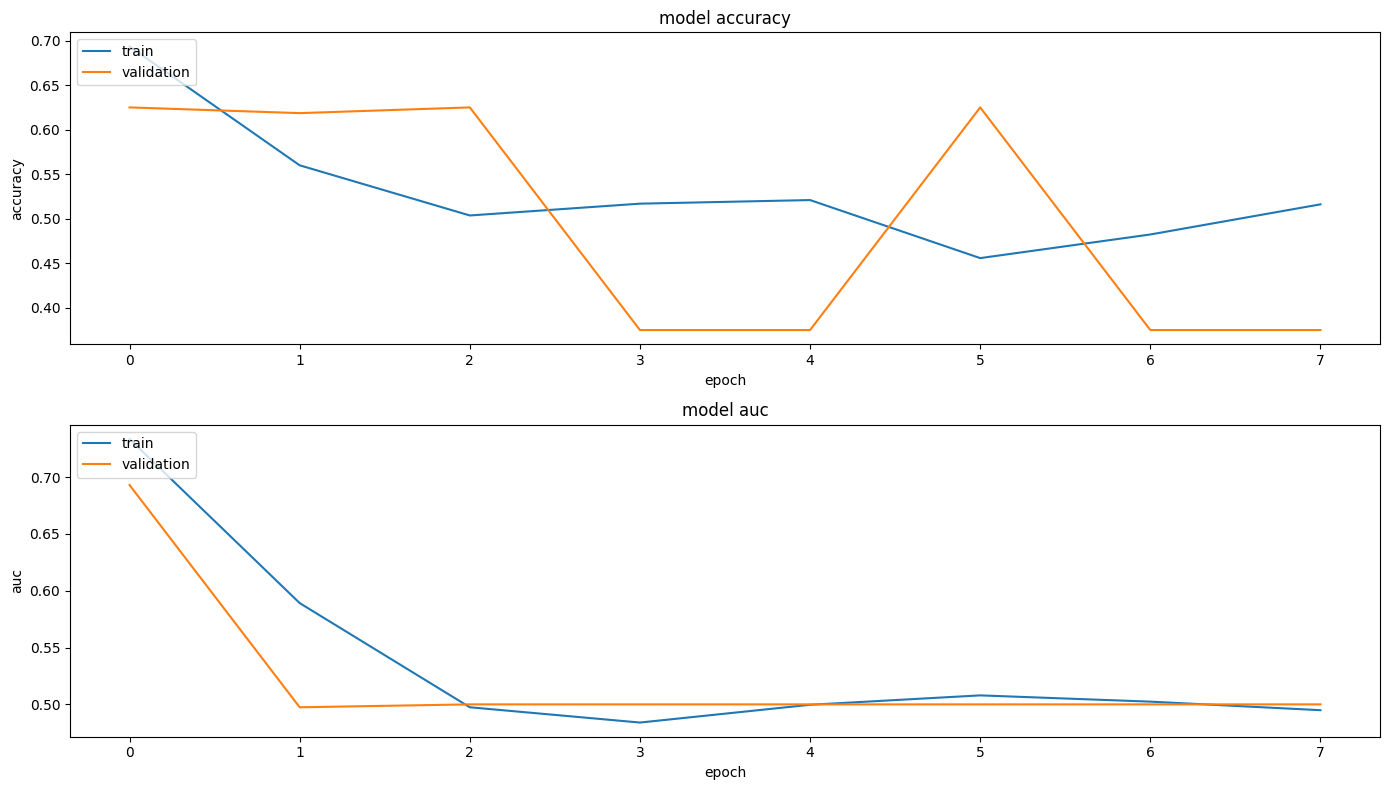

In [33]:
visualize_accuracy(aug_complex_cnn_fit)

### Create Statistical Reports

In [34]:
aug_simple_cnn_class_report = class_report(aug_complex_cnn_model)
aug_simple_cnn_class_report

78/78 [==============================] - 15s 189ms/step
[[234   0]
 [390   0]]
Our classification report is: 
                    0      1  accuracy   macro avg  weighted avg
precision    0.375000    0.0     0.375    0.187500      0.140625
recall       1.000000    0.0     0.375    0.500000      0.375000
f1-score     0.545455    0.0     0.375    0.272727      0.204545
support    234.000000  390.0     0.375  624.000000    624.000000


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [40]:
evaluation = aug_complex_cnn_model.evaluate(test)
print(f"Test Accuracy: {evaluation[1] * 100:.2f}%")

evaluation = aug_complex_cnn_model.evaluate(train)
print(f"Train Accuracy: {evaluation[1] * 100:.2f}%")

78/78 [==============================] - 24s 297ms/step - loss: 0.7059 - accuracy: 0.3750 - auc_2: 0.5000
Test Accuracy: 37.50%
651/651 [==============================] - 136s 210ms/step - loss: 0.7169 - accuracy: 0.2578 - auc_2: 0.5000
Train Accuracy: 25.78%


## ResNet50 Model

### Load our model

In [35]:
resnet_model = ResNet50(input_shape=(180,180,3), 
                        include_top=False, 
                        weights='imagenet')

94765736/94765736 [==============================] - 3s 0us/step


### Copy the Papers steps
 - Load up the model
 - Add additional layers
 - See the results

In [36]:
# COPYING THE PAPER HERE -- take the ResNet model, add in a few more layers, voila -- hopefully this works
resnet_model = tf.keras.Sequential([
        # Using Sequential(), we first load up our ResNet50 pre-trained model, then add additional layers
        resnet_model,

        GlobalAveragePooling2D(),

        Dense(512, 
              activation="relu"),

        BatchNormalization(),

        Dropout(0.6),

        Dense(128, 
              activation="relu"),

        BatchNormalization(),

        Dropout(0.4),

        Dense(64, 
              activation="relu"),

        BatchNormalization(),

        Dropout(0.3),

        Dense(1, 
              activation="sigmoid")
    ])

# get our optimizing function
OPTIMIZATION_FUNC = optimizers.Adam(learning_rate=0.01)

#get our metrics
METRICS = [
    'accuracy',
    metrics.Precision(name='precision'),
    metrics.Recall(name='recall')
]

#compile our model
resnet_model.compile(optimizer = OPTIMIZATION_FUNC, 
                     loss = 'binary_crossentropy', 
                     metrics = METRICS)

### Fit the Model

In [37]:
resnet_fit_model = resnet_model.fit(train,
          epochs=5,
          validation_data=test,
          class_weight=CLASS_WEIGHT,
          steps_per_epoch=200,
          validation_steps=25)

Epoch 1/5
200/200 [==============================] - 980s 5s/step - loss: 0.2769 - accuracy: 0.5775 - precision: 0.8114 - recall: 0.5614 - val_loss: 2.8443 - val_accuracy: 0.6350 - val_precision: 0.6263 - val_recall: 0.9835
Epoch 2/5
200/200 [==============================] - 987s 5s/step - loss: 0.2359 - accuracy: 0.6400 - precision: 0.8691 - recall: 0.6051 - val_loss: 2.2175 - val_accuracy: 0.6200 - val_precision: 0.8438 - val_recall: 0.4500
Epoch 3/5
200/200 [==============================] - 967s 5s/step - loss: 0.1782 - accuracy: 0.7842 - precision: 0.9323 - recall: 0.7624 - val_loss: 1.7088 - val_accuracy: 0.3850 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 4/5
200/200 [==============================] - 975s 5s/step - loss: 0.1825 - accuracy: 0.7800 - precision: 0.9318 - recall: 0.7593 - val_loss: 0.9209 - val_accuracy: 0.5900 - val_precision: 0.9512 - val_recall: 0.3277
Epoch 5/5
200/200 [==============================] - 967s 5s/step - loss: 0.1549 - accuracy: 0.8

### Classification Report

In [38]:
evaluation =resnet_model.evaluate(test)
print(f"Test Accuracy: {evaluation[1] * 100:.2f}%")

evaluation = resnet_model.evaluate(train)
print(f"Train Accuracy: {evaluation[1] * 100:.2f}%")

78/78 [==============================] - 86s 1s/step - loss: 1.0786 - accuracy: 0.4728 - precision: 0.5604 - recall: 0.7256
Test Accuracy: 47.28%
651/651 [==============================] - 728s 1s/step - loss: 0.9412 - accuracy: 0.5765 - precision: 0.6950 - recall: 0.7653
Train Accuracy: 57.65%


# Overall Results

**BEST** Overall Results: 

1.   *Simple CNN* - **74.22% accuracy**
2.   *Complex CNN* - **96.73% accuracy**

Model Tuning:
4.   *Augmented Data on Complex CNN* - **25.78% accuracy**

ResNet50 With Layers
5.   *ResNet50 with Additional Layers* - **57.65% accuracy** (**NOTE** -- due to how long each epoch took, I only ran 5 epochs instead of the 10 epochs for all the other models. The results would have been better on further training and better hyperparameter tuning)


Key take aways:

1.   More complex is not always better! The Simple 2-Layer CNN model produced just as well as the ResNet model and the Augmented Data model; and our complex handmade CNN produced better than the others!
3.   Data augmentation is a common model tuning technique to improve results in CNN's, but unfortunately here it failed. To really tune this better, I would need to optimize over the data augmentation variables. Again, due to time constraints and scope of the project, the data augmentation was not optimized or further tested.
4.   Lastly - ways to get better results from our very poor models:
  - **Tweak hyperparameters** - Things we could change are the `learning rate`, the `number of epochs`, the `batch sizes`, and the `various filters` and `strides`. In order to get a better result, we would look to optimize each parameter, and let the algo run and produce a better result. Due to time/computer restraints, this is something that we will leave as is for the time being
  - **Get more Data** - Due to only have ~600 images total in the test and 5200 in the training, the amount of data isnt enough to produce results that would be able to be put into production. The more data, the more reliable the model and algo, and the less error. Working with this small amount of data was nice for Google Collab as it didnt cause many cluster failures 
  - **Optimize CNN Layers** - We obviously only created 2- and 4- layer CNN's and we can clearly see they were not optimized. With a deeper understanding of CNN infrastructure, more compute resources, and more time, the layers could be optimized such that it accurately makes predictions. Things like `pool_size`, `strides`, `kernels`, `filters`, etc...could all be optimized in a better fashion than we did.







____